<a href="https://colab.research.google.com/github/jesvin1/Basics/blob/master/Nifty_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing the required packages

In [2]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=73011f8c20e510d9fc89bd8f790adb19d95adee6167b786b1937ebfbfbbb7824
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [0]:
# imports datetime for picking beginning and end dates for the analysis
import datetime
# imports yahoo finance for getting historical stock prices
import yfinance as yf
# imports pandas for dataframe manipulation
import pandas as pd
# imports numpy
import numpy as np
# for data visualization
import matplotlib as mpl
# for changing the plot size in the Jupyter Notebook output
%matplotlib inline
# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)
# for shorter lines with plotting
from matplotlib import pyplot as plt
# to hide warning messages
import warnings
warnings.filterwarnings('ignore')
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import coint

# sets the sample period as 5 years back from 09/12/2019
end = datetime.datetime(2019, 9, 12)
start = end - datetime.timedelta(days = 13*365) #including the recession time




#Function for Ploting, Stationary testing and to find Best ARIMA

In [0]:
def tsplot(y, lags=None, figsize=(10, 8), style='seaborn-bright'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax, linewidth=1.5)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()
    
    return

In [0]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True, test_type='adfuller'):
        x=np.asarray(timeseries.dropna())
        #Since the p-value is less than any significant level of aplha, 
        #we can reject the Null and conclude that data do not follow a normal distribution.
        print('P-value less its normal distribution',scs.jarque_bera(x))

        if test_type=='adfuller':
            
            #Dickey-Fuller test:
            adfTest = adfuller(timeseries, autolag='AIC')

            self.pValue = adfTest[1]

            if (self.pValue<self.SignificanceLevel):
                self.isStationary = True
            else:
                self.isStationary = False

            if printResults:
                dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

                #Add Critical Values
                for key,value in adfTest[4].items():
                    dfResults['Critical Value (%s)'%key] = value

                print('####################################Augmented Dickey-Fuller Test Results:####################################')
                print(dfResults)
                print("Is the time series stationary? {0}".format(sTest.isStationary))
        if test_type =='adfuller':
            
            #Kwiatkowski-Phillips-Schmidt-Shin test for stationarity:
            kpssTest = kpss(timeseries)

            self.pValue = kpssTest[1]

            if (self.pValue<self.SignificanceLevel):
                self.isStationary = True
            else:
                self.isStationary = False

            if printResults:
                kpssResults = pd.Series(kpssTest[0:4], index=['KPSS Test Statistic','P-Value','# Lags Used','# Observations Used'])

                '''#Add Critical Values
                for key,value in kpssTest[4].items():
                    dfResults['Critical Value (%s)'%key] = value'''

                print('####################################KPSS Test Results:####################################')
                print(kpssResults)
                print("Is the time series stationary? {0}".format(sTest.isStationary))


In [0]:
def best_arima(df):
    # to suppress warnings
    warnings.filterwarnings('ignore')

    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(df, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    tsplot(best_mdl.resid, lags=30)
    from statsmodels.stats.stattools import jarque_bera

    score, pvalue, _, _ = jarque_bera(best_mdl.resid)
    if pvalue < 0.05:
        print("Our residuals are likely not normally distributed.")
    else:
        print("Our residuals are likely normally distributed.")
    return best_aic, best_order, best_mdl

#Working with the Data

In [7]:
# gets the closing price fo HDFC for the past 7 years
my_stock = yf.Ticker('^NSEI')
my_stock = pd.DataFrame(my_stock.history(start = start, end = end)['Close'])
my_stock = my_stock.rename(str.lower, axis = 'columns')
my_stock.head()

,close
Date,
2007-09-17,4494.65
2007-09-18,4546.20
2007-09-19,4732.35
2007-09-20,4747.55
2007-09-21,4837.55


##Checking for Stationarity

In [8]:
sTest = StationarityTests()
#my_stock['daily_ret']=my_stock.close.pct_change(1)
sTest.ADF_Stationarity_Test(my_stock.close.dropna(), printResults = True)

####################################Augmented Dickey-Fuller Test Results:####################################
ADF Test Statistic        -0.287236
P-Value                    0.927293
# Lags Used                7.000000
# Observations Used     2918.000000
Critical Value (1%)       -3.432593
Critical Value (5%)       -2.862531
Critical Value (10%)      -2.567298
dtype: float64
Is the time series stationary? False
####################################KPSS Test Results:####################################
KPSS Test Statistic                                              9.08004
P-Value                                                             0.01
# Lags Used                                                           28
# Observations Used    {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...
dtype: object
Is the time series stationary? True


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


##Differencing to make the data stationary



In [0]:
n_diff_dataset = pd.DataFrame(data=np.diff(np.array(my_stock['close'])))
n_diff_dataset.columns = ['close']

In [24]:
sTest.ADF_Stationarity_Test(n_diff_dataset.close.dropna(), printResults = True)

####################################Augmented Dickey-Fuller Test Results:####################################
ADF Test Statistic       -21.221197
P-Value                    0.000000
# Lags Used                6.000000
# Observations Used     2918.000000
Critical Value (1%)       -3.432593
Critical Value (5%)       -2.862531
Critical Value (10%)      -2.567298
dtype: float64
Is the time series stationary? True
####################################KPSS Test Results:####################################
KPSS Test Statistic                                             0.073293
P-Value                                                              0.1
# Lags Used                                                           28
# Observations Used    {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...
dtype: object
Is the time series stationary? False


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


#Finding the Best ARIMA

aic: 33726.34075 | order: (3, 1, 3)
Our residuals are likely not normally distributed.


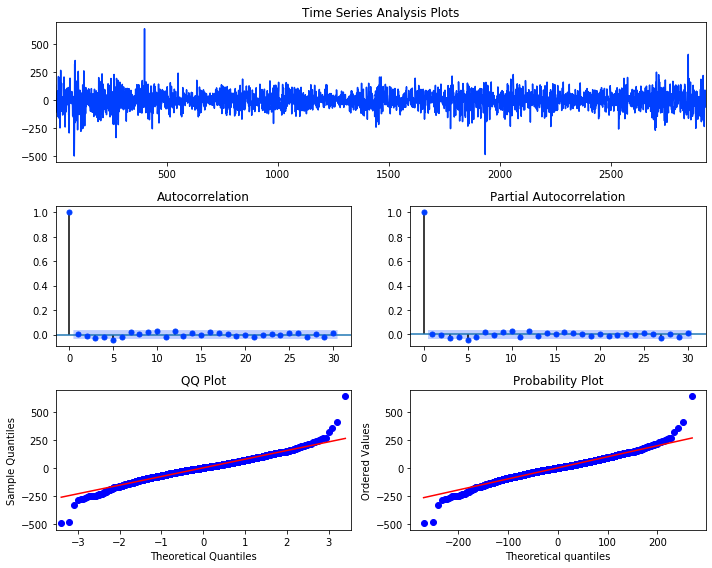

In [25]:
# Find the best ARIMA fit
res_tup = best_arima(n_diff_dataset)
order = res_tup[1]
model = res_tup[2]
    
    # Now that we have our ARIMA fit, we feed this to the GARCH model
p_ = order[0]
o_ = order[1]
q_ = order[2]